# Preparing utils

In [1]:
import numpy as np
from itertools import product
import pandas as pd
from IPython.display import display

In [2]:
def make_neighbour_indices(n):
    return np.dstack((np.arange(n)[:-1], np.arange(n)[1:])).reshape((-1, 2))

def H(spins, pair_indices, couplings=None, magnetic_fields=None):
    n = len(spins)

    if couplings is None:
        couplings = np.zeros((n, n))
        couplings[pair_indices[:,0], pair_indices[:,1]] = np.ones(len(pair_indices))
    
    if magnetic_fields is None:
        magnetic_fields = np.zeros(n)
        
    return (- spins.T @ couplings @ spins - magnetic_fields @ spins).item()

def Z(n, pair_indices, beta=1, **kwargs):
    z = 0
    for spins in product([-1, 1], repeat=n):
        z += np.exp(-beta * H(np.array(spins), pair_indices, **kwargs))
    return z

def Pr(spins, pair_indices, beta=1, **kwargs):
    return np.exp(-beta * H(spins, pair_indices, **kwargs)) / Z(len(spins), pair_indices, beta=beta, **kwargs)

In [3]:
def get_probs_distribution(n):
    configs, probs = [], []
    for spins in product([-1, 1], repeat=n):
        configs.append(list(spins))   
        probs.append(Pr(np.array(spins), make_neighbour_indices(n)))

    display(pd.DataFrame({'s': configs, 'Pr[s]': probs}))

get_probs_distribution(3)

,s,Pr[s]
0,"[-1, -1, -1]",0.387902
1,"[-1, -1, 1]",0.052497
2,"[-1, 1, -1]",0.007105
3,"[-1, 1, 1]",0.052497
4,"[1, -1, -1]",0.052497
5,"[1, -1, 1]",0.007105
6,"[1, 1, -1]",0.052497
7,"[1, 1, 1]",0.387902


# IBM Quantum computer processing

In [4]:
from qiskit import *
%matplotlib inline

In [10]:
def S_gate(J=1, beta=1):
    x = np.exp(beta/2)
    c = 0.5 * Z(2, np.array([[0, 1]]))
    mat = 1/c**(1/2) * np.array(
    [
        [x**J, x**(-J), 0, 0],
        [-x**(-J), x**J, 0, 0],
        [0, 0, x**(-J), x**J],
        [0, 0, -x**J, x**(-J)]
    ]
    )
    s_gate = qiskit.extensions.UnitaryGate(mat, 'S')
    return s_gate


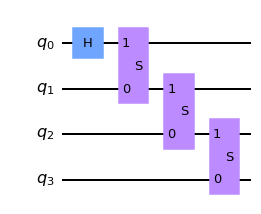

In [15]:
qr = QuantumRegister(4, 'q')
circ = QuantumCircuit(qr)
circ.h(0)
circ.append(S_gate(), [qr[1], qr[0]])
circ.append(S_gate(), [qr[2], qr[1]])
circ.append(S_gate(), [qr[3], qr[2]])

circ.draw('mpl')

In [16]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()

### Simulated probability distribution

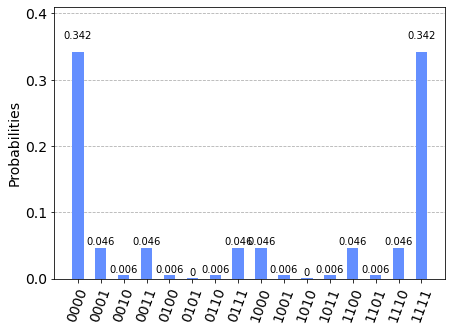

In [17]:
qiskit.visualization.plot_histogram(result.get_counts(circ))

### True probability distribution

In [19]:
get_probs_distribution(4)

,s,Pr[s]
0,"[-1, -1, -1, -1]",0.341663
1,"[-1, -1, -1, 1]",0.046239
2,"[-1, -1, 1, -1]",0.006258
3,"[-1, -1, 1, 1]",0.046239
4,"[-1, 1, -1, -1]",0.006258
5,"[-1, 1, -1, 1]",0.000847
6,"[-1, 1, 1, -1]",0.006258
7,"[-1, 1, 1, 1]",0.046239
8,"[1, -1, -1, -1]",0.046239
9,"[1, -1, -1, 1]",0.006258


# D-Wave quantum computer processing

In [45]:
import dimod

In [46]:
n = 4
bqm = dimod.BinaryQuadraticModel({i: 0 for i in range(n)},
                                 {(i, i + 1): -1 for i in range(n - 1)},
                                  0,
                                  dimod.Vartype.SPIN)

### Configurations distribution

In [47]:
sampler = dimod.ExactSolver()
solution = sampler.sample(bqm)

print(solution)

    0  1  2  3 energy num_oc.
0  -1 -1 -1 -1   -3.0       1
10 +1 +1 +1 +1   -3.0       1
1  +1 -1 -1 -1   -1.0       1
2  +1 +1 -1 -1   -1.0       1
5  +1 +1 +1 -1   -1.0       1
8  -1 -1 +1 +1   -1.0       1
11 -1 +1 +1 +1   -1.0       1
15 -1 -1 -1 +1   -1.0       1
3  -1 +1 -1 -1    1.0       1
4  -1 +1 +1 -1    1.0       1
7  -1 -1 +1 -1    1.0       1
9  +1 -1 +1 +1    1.0       1
13 +1 +1 -1 +1    1.0       1
14 +1 -1 -1 +1    1.0       1
6  +1 -1 +1 -1    3.0       1
12 -1 +1 -1 +1    3.0       1
['SPIN', 16 rows, 16 samples, 4 variables]


### Finding lowest energy solution

In [48]:
from dwave.system import DWaveSampler
from dwave.system import EmbeddingComposite


sampler = DWaveSampler() 
embedding_sampler = EmbeddingComposite(sampler)
sampleset = embedding_sampler.sample(bqm, num_reads=1000)

In [49]:
print(str(sampleset))

   0  1  2  3 energy num_oc. chain_.
0 +1 +1 +1 +1   -3.0     689     0.0
1 -1 -1 -1 -1   -3.0     310     0.0
2 -1 +1 +1 +1   -1.0       1     0.0
['SPIN', 3 rows, 1000 samples, 4 variables]
